# Short Rate Forecasting with Vasicek and CIR Models using LSTM

This notebook explores **interest rate modeling** using two classical stochastic short-rate models — the **Vasicek** and **Cox-Ingersoll-Ross (CIR)** models — and applies an **LSTM neural network** to forecast future short rates.

The project steps:
1. Simulate short-rate paths using Vasicek and CIR models.
2. Prepare the simulated data for ML forecasting.
3. Train an LSTM network to predict future rates.
4. Evaluate model performance using MAE, RMSE, and MAPE.
5. Visualize predictions and compare with true rates.

In [1]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt

# For ML
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

## Vasicek Model

The **Vasicek model** is a mean-reverting model for interest rates:

$$ dr_t = a(b - r_t)dt + \sigma dW_t $$

Where:
- $r_t$: short rate at time $t$
- $a$: speed of mean reversion
- $b$: long-term mean interest rate
- $\sigma$: volatility
- $W_t$: Wiener process (Brownian motion)

Pros:
- Simple and analytically tractable.

Cons:
- Allows **negative interest rates** (not always realistic).


In [2]:
# Vasicek model simulation
def vasicek_sim(r0, a, b, sigma, T, dt):
    N = int(T/dt)
    rates = [r0]
    for _ in range(N):
        dr = a * (b - rates[-1]) * dt + sigma * np.sqrt(dt) * np.random.normal()
        rates.append(rates[-1] + dr)
    return np.array(rates)

## Cox-Ingersoll-Ross (CIR) Model

The **CIR model** modifies Vasicek to ensure rates remain positive:

$$ dr_t = a(b - r_t)dt + \sigma \sqrt{r_t} dW_t $$

This ensures $r_t \geq 0$ as long as the **Feller condition** holds:

$$ 2ab \geq \sigma^2 $$

Where:
- $r_t$: short rate at time $t$
- $a$: speed of mean reversion
- $b$: long-term mean interest rate
- $\sigma$: volatility
- $W_t$: Wiener process (Brownian motion)

**Pros:**
- Keeps interest rates non-negative.

**Cons:**
- Slightly more complex than Vasicek.

In [3]:
# CIR model simulation
def cir_sim(r0, a, b, sigma, T, dt):
    N = int(T/dt)
    rates = [r0]
    for _ in range(N):
        sqrt_r = np.sqrt(max(rates[-1], 0))
        dr = a * (b - rates[-1]) * dt + sigma * sqrt_r * np.sqrt(dt) * np.random.normal()
        rates.append(max(rates[-1] + dr, 0))
    return np.array(rates)

## LSTM Forecasting

- **Why LSTM?**  
  LSTMs (Long Short-Term Memory networks) are a type of recurrent neural network designed to capture long-term dependencies in sequential data, making them suitable for time-series forecasting.

- **Our Approach:**  
  1. Transform simulated rates into supervised learning format with a lag window.
  2. Train LSTM to predict one-step-ahead rates.
  3. Evaluate predictions using:
     - **MAE** (Mean Absolute Error)
     - **RMSE** (Root Mean Squared Error)
     - **MAPE** (Mean Absolute Percentage Error)


4/4 [==============================] - 0s 3ms/step
MAE: 0.002398
RMSE: 0.002913
MAPE: 2.97%


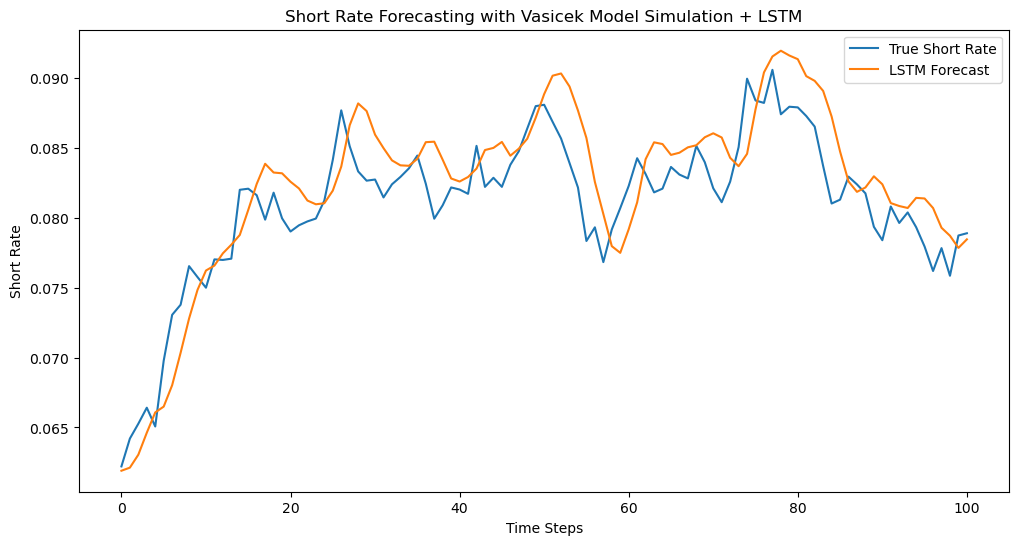

4/4 [==============================] - 0s 2ms/step
MAE: 0.000420
RMSE: 0.000517
MAPE: 1.19%


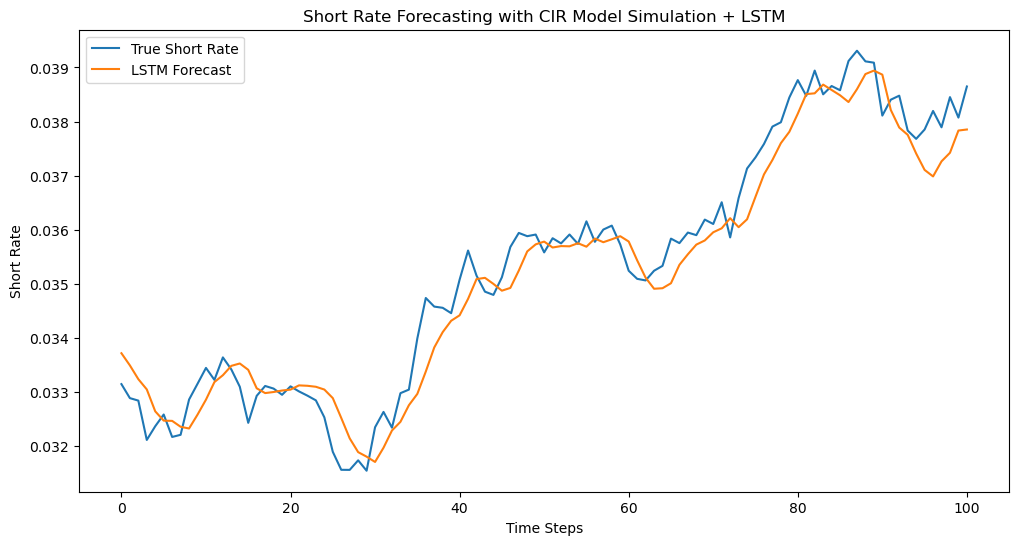

In [4]:
# Prepare LSTM dataset
def prepare_lstm_data(series, n_lags=10):
    X, y = [], []
    for i in range(len(series) - n_lags):
        X.append(series[i:(i + n_lags)])
        y.append(series[i + n_lags])
    X = np.array(X)
    y = np.array(y)
    # Reshape for LSTM [samples, timesteps, features]
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y

# Forecasting function
def train_forecast_lstm(train_series, test_series, n_lags=10, epochs=20, batch_size=16):
    scaler = MinMaxScaler(feature_range=(0, 1))
    train_scaled = scaler.fit_transform(train_series.reshape(-1, 1))
    test_scaled = scaler.transform(test_series.reshape(-1, 1))

    X_train, y_train = prepare_lstm_data(train_scaled, n_lags)
    X_test, y_test = prepare_lstm_data(test_scaled, n_lags)

    model = Sequential([
        LSTM(50, activation='relu', input_shape=(n_lags, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled).flatten()
    y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    return y_true, y_pred

# Evaluation metrics
def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    # Avoid divide by zero for MAPE calculation
    non_zero = y_true != 0
    mape = np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100
    return mae, rmse, mape

# Parameters
r0 = 0.03
a = 0.1
b = 0.05
sigma = 0.02
T = 5.0       # 5 years
dt = 0.01

# Simulate Vasicek short rates
rates_vasicek = vasicek_sim(r0, a, b, sigma, T, dt)

# Split into train and test (80% train)
split_idx = int(len(rates_vasicek) * 0.8)
train_series = rates_vasicek[:split_idx]
test_series = rates_vasicek[split_idx - 10:]  # include lag window for test prep

# Train and forecast with LSTM
y_true, y_pred = train_forecast_lstm(train_series, test_series, n_lags=10, epochs=30)

# Evaluate
mae, rmse, mape = evaluate_forecast(y_true, y_pred)
print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAPE: {mape:.2f}%")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_true)), y_true, label='True Short Rate')
plt.plot(range(len(y_pred)), y_pred, label='LSTM Forecast')
plt.xlabel('Time Steps')
plt.ylabel('Short Rate')
plt.title('Short Rate Forecasting with Vasicek Model Simulation + LSTM')
plt.legend()
plt.show()

# Simulate CIR short rates
rates_cir = cir_sim(r0, a, b, sigma, T, dt)

# Split into train and test (80% train)
split_idx = int(len(rates_cir) * 0.8)
train_series = rates_cir[:split_idx]
test_series = rates_cir[split_idx - 10:]  # include lag window for test prep

# Train and forecast with LSTM
y_true, y_pred = train_forecast_lstm(train_series, test_series, n_lags=10, epochs=30)

# Evaluate
mae, rmse, mape = evaluate_forecast(y_true, y_pred)
print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"MAPE: {mape:.2f}%")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_true)), y_true, label='True Short Rate')
plt.plot(range(len(y_pred)), y_pred, label='LSTM Forecast')
plt.xlabel('Time Steps')
plt.ylabel('Short Rate')
plt.title('Short Rate Forecasting with CIR Model Simulation + LSTM')
plt.legend()
plt.show()

## Results Interpretation

- **MAE** tells us the average absolute forecast error size.
- **RMSE** penalizes large errors more than MAE.
- **MAPE** expresses forecast error in percentage terms.

We trained the LSTM separately on Vasicek and CIR simulated data:
- Compare whether LSTM performs better on Vasicek (possibly smoother) vs CIR (more volatility at low rates).
- Lower error metrics indicate better forecasts.

As can be seen from the error metrics obtained for both **"Vasicek + LSTM Simulation"** and **"CIR + LSTM Simulation"**, the errors in case of the latter are quite lower than those in case of the former.

**Note:** Since we used simulated data, real-world performance with historical rates may differ.
